# Welcome to the IMCity Trading Challenge!


# Some Notes

## Requirements

Python >=3.11

**Packages:**

requests>=2.32.2

sseclient-py>=1.8.0

## Exchange GUI

- The test exchange will be sent out via email to all registered participants (register [here](https://tinyurl.com/IMC-Challenge))
- The real exchange will be announced on Saturday morning.

## Rules

- The aim of this challenge is to write an automated algorithm to trade
- Do not manipulate or interfere with other teams’ bots or the exchange. **Don't try to break things!**
- No collusion or coordinated trading between teams
- Keep API usage efficient — don’t hammer endpoints (max 1 request/sec, preferably less)
- Don’t spawn excessive connections or threads
- Hard position limits are applied (±200 long or short position per product)
- Be curious, collaborative, and competitive — but keep the system running for everyone

## Scoring

- For each product, we normalize your PnL by the sum of all positive PnLs across teams in that product.
- This makes each product’s score a percentage share of the achievable positive PnL.
- Teams with losses still have negative PnL, which will reduce their total score.
- The ETF product counts double — its normalized score is multiplied by 2.
- Your final total score is the sum of all product scores.

## Optional features

Sections marked as optional below are features supported by the exchange but not necessarily needed for writing a working arbitrager script. However, you are more than welcome to try it!



## Setting up

We first need an custom bot to send orders and read market data.


In [32]:
from imcity_template import BaseBot, Side, OrderRequest, OrderBook, Order

In [33]:
TEST_EXCHANGE = "http://ec2-52-31-108-187.eu-west-1.compute.amazonaws.com" # TODO
REAL_EXCHANGE = "" # TODO

username = "RoboTraders"  # TODO: Change this to your team's username you've created in CMI
password = "theshowgoeson"  # TODO: Change this to be your team's password you've created in CMI

## Simple bot

This Python wrapper already provides all the core functionality needed to build a trading bot.

### Listening and Reacting to Events
- The `on_orderbook` handler is triggered whenever the order book for a product updates.
- The `on_trades` handler is triggered whenever one of your own orders executes.
- Note that a trade also changes the order book — so each trade will trigger both an `on_trades` callback and an `on_orderbook` update.


In [34]:
class CustomBot(BaseBot):

    # Handler for own trades
    def on_trades(self, trades: list[dict]):
        for trade in trades:
            print(f"{trade['volume']} @ {trade['price']}")

    # Handler for order book updates
    def on_orderbook(self, orderbook: OrderBook):
        print(orderbook)
        do_i_want_to_buy = False
        if do_i_want_to_buy:
            order = OrderRequest(product=orderbook.product,
                                 price=orderbook.sell_orders[0].price,
                                 volume=1,
                                 side=Side.BUY)
            self.send_order(order)


### Running the bot

The code snippet below shows how to run your bot — even directly from a notebook.
Calling `start` launches an SSE thread in the background that automatically subscribes to trade and order book updates.
This thread handles all data streaming and event management for you, allowing you to focus entirely on your execution logic.

In [35]:
try:
    bot = CustomBot(TEST_EXCHANGE, username, password)
    bot.start()

    while True:
        pass
except KeyboardInterrupt as e:
    bot.stop()

Starting SSEThread...
SSEThread started.
Closing SSE Thread...


KeyboardInterrupt: 

## Viewing the market

We can view the current market state on every orderbook change in the `on_orderbooks` handler.

Here is an example of an orderbook from the `on_orderbook` handler. The object contains all `buy_orders` sorted by decreasing price and `sell_orders` sorted by increasing price.


In [ ]:
orderbook = OrderBook(
    product="PRODUCT",
    tick_size=0.5,
    buy_orders=[
        Order(price=100, volume=1, own_volume=1),
        Order(price=99, volume=1, own_volume=0),
    ],
    sell_orders=[
        Order(price=101, volume=1, own_volume=1),
        Order(price=102, volume=1, own_volume=0),
    ],
)

orderbook.buy_orders[0]

The first quote in the buy orders gives the current best `bid` price, `orderbook.buy_orders[0].price`, and the quantity someone is willing to buy at.

And the first quote in the sell orders gives the current best `ask` price and volume someone is willing to sell at.


In [ ]:
orderbook.buy_orders[0].price, orderbook.buy_orders[0].volume

## Viewing trades

To monitor your executed trades, the `on_trades` callback publishes all trades that involve your own username.
You will only appear on the side of the trade that you participated in — the counterparty field will be empty for your own side.

Below is an example of a trade update received in `on_trades`, showing a case where you were the buyer of 10 units of PRODUCT at a price of 27.0.

In [ ]:
trades = [{'timestamp': '2025-11-21T10:40:42.438180497Z', 'sessionId': 'FISH', 'product': 'PRODUCT', 'buyer': 'username', 'seller': '', 'aggressor': '', 'volume': 10, 'price': 27.0}]

## Sending Orders

Now that we've set up our bot, let's get into making some orders!

### Quote - Good For Day Orders (GFD)

GFD orders are orders that will remain on the market until they are fully filled. This is commonly known as 'quoting', and we can make quotes with our instance `bot` that we defined above.

In [ ]:
# Send an GFD order to Sell 1 PRODUCT at price 500
bot.send_order(OrderRequest(product="1_Eisbach", side=Side.BUY, price=5000, volume=1))

### Hit - Immediate or Cancel Orders (IOC) (Optional)

IOC orders are orders that will either be filled (either partially or fully), and if not, cancelled. The remaining units that cannot be immediately filled will not remain on the market. This is commonly known as "hitting". We can replicate an IOC order by sending a quote and directly canceling it again based of the remaining volume from the OrderResponse.

In [ ]:
# Send a GFD order to Buy 10 lettuce at price 5 and cancel the order if any unmatched volume remains
order_response = bot.send_order(OrderRequest(product="1_Eisbach", side=Side.SELL, price=5, volume=10))
if order_response and order_response.volume > 0:
    cancel_response = bot.cancel_order_by_id(order_response.id)

Note here in the return value of `bot.send_order`, there is a `filled` attribute that tells you the volume filled when you sent the order.


## Cancel an Order (Optional)

As already introduced for the IOC order, for each order we get an `orderResponse` dataclass object. We can use this `orderResponse` to cancel any orders we think might be no longer attractive to keep on the market.


In [ ]:
bot.cancel_order_by_id(order_response.id)

### Mass Cancel All Orders (Optional)

If the market has shifted too quickly for us, we can cancel all the quotes we have on the market. We can cancel for every symbol or for a particular symbol and price.


In [ ]:
bot.cancel_all_orders()

In [ ]:
bot.cancel_order(product="PRODUCT", price=50)

## View your current position (Optional but recommended)

To make sure you stay within the **position limits** (±200 per product), you can query your current holdings per product using `request_positions`.
This method returns a dictionary of the form: {"PRODUCT_NAME": position}

In [ ]:
bot.request_positions()

## View your current orders (Optional)

You can also view the current orders you've made on the market.


In [ ]:
bot.request_all_orders()

# Calculating Estimates over the different metrics

Daten erfolgreich geladen:
                     wasserstand
timestamp                       
2025-11-16 00:00:00          139
2025-11-16 01:00:00          139
2025-11-16 02:00:00          139
2025-11-16 03:00:00          138
2025-11-16 04:00:00          140
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 147 entries, 2025-11-16 00:00:00 to 2025-11-22 02:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   wasserstand  147 non-null    int64
dtypes: int64(1)
memory usage: 2.3 KB
None


0

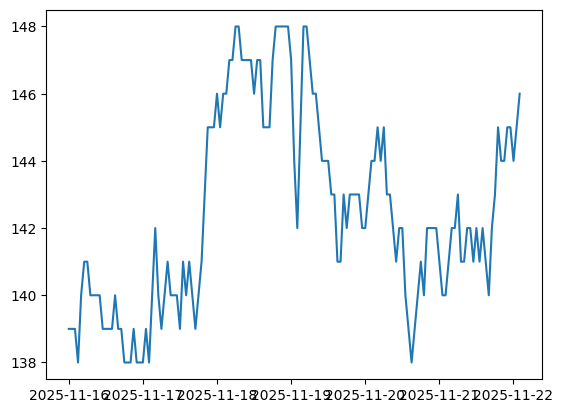

In [1]:
import estimates

estimates.scrape_waterlevel()